# Benchmark for Clustering

In [53]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import locally_popular_clustering, extract_labels_from_communities, time_tester, calculate_scores_clustering, \
    locally_popular_clustering_with_euclid_graphs

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_pos_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity



## Create Graphs

In [54]:
repetitions = 1    #Number of random isomorph permutation for each graph


moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)
moon_perm_agents = []
moon_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(moon_agents,moon_truth)
    moon_perm_agents += [g]
    moon_perm_truth += [t]



circle_agents, circle_truth = my_make_circles(300)

circle_perm_agents = []
circle_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(circle_agents,circle_truth)
    circle_perm_agents += [g]
    circle_perm_truth += [t]

cancer = load_breast_cancer()

cancer_agents = cancer['data']
cancer_truth = cancer['target']

cancer_perm_agents = []
cancer_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(cancer_agents,cancer_truth)
    cancer_perm_agents += [g]
    cancer_perm_truth += [t]

iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']


iris_perm_agents = []
iris_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(iris_agents,iris_truth)
    iris_perm_agents += [g]
    iris_perm_truth += [t]


## Run the algorithms


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [67]:
import itertools
import timeit
import pandas as pd

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    f = treshold[0]   #f-bound
    e = treshold[1]   
    data = [ moon_perm_agents,circle_perm_agents,cancer_perm_agents,iris_perm_agents]
    expected_clusters = [2,3,2,3]
    graph_names = ['Moons','My 3 Circles', 'Cancer', 'Iris']
    graph_truths =  [moon_perm_truth,circle_perm_truth,cancer_perm_truth,iris_perm_truth]
    
    
    kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
    dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)
    
    kmeans_out = None
    dbscan_out = None
    
    lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='B',pre=pre)
    lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='F',pre=pre)
    lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='E',pre=pre)
    
    algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
    algo_names = [ 'kmeans', 'dbscan','LP (Balanced) Heuristic',\
                   'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
    is_lp_heuristic = [False,False,True, True, True]
    
    collected_data = {}
    
    for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
        itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
    
            
        agents = graph
    
        if lp_heuristic:
            # start with everyone alone
            a_name_modified = a_name + ' starting with everyone alone'
            print(f"Running {a_name_modified} on {g_name} … ", end='')
            test_callable = lambda a: list(algo(a,len(agents[0]),None).values())
            times,outputs = time_tester(test_callable,graph)
            avg_time = sum(times)/len(times)
            scores = calculate_scores_clustering(outputs,truth,agents)
            scores['Time'] = avg_time
    
            collected_data[(a_name_modified,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
            # start with random clustering 
    
            a_name_modified = a_name + ' starting with predicted number of clusters'
            print(f"Running {a_name_modified} on {g_name} … ", end='')
            test_callable = lambda a: list(algo(a,clusters,None).values())
            times,outputs = time_tester(test_callable,graph)
            avg_time = sum(times)/len(times)
            scores = calculate_scores_clustering(outputs,truth,agents)
            scores['Time'] = avg_time
    
            collected_data[(a_name_modified,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
    
            # start with the output of k-means
            a_name_modified = a_name + ' starting with the output of k-means'
            print(f"Running {a_name_modified} on {g_name} … ", end='')
            test_callable = lambda a: list(algo(a,clusters,kmeans).values())
            times,outputs = time_tester(test_callable,graph)
            avg_time = sum(times)/len(times)
            scores = calculate_scores_clustering(outputs,truth,agents)
    
            rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
            scores['Rand Score with initial clustering'] = rand_score_with_init
            
            scores['Time'] = avg_time
    
            collected_data[(a_name_modified,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
            # start with the output of dbscan
            a_name_modified = a_name + ' starting with the output of dbscan'
            print(f"Running {a_name_modified} on {g_name} … ", end='')
            test_callable = lambda a: list(algo(a,clusters,kmeans).values())
            times,outputs = time_tester(test_callable,graph)
            avg_time = sum(times)/len(times)
    
            rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
            scores['Rand Score with initial clustering'] = rand_score_with_init
            
            scores = calculate_scores_clustering(outputs,truth,agents)
            scores['Time'] = avg_time
    
            collected_data[(a_name_modified,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
                
        else:
    
            print(f"Running {a_name} on {g_name} … ", end='')
            test_callable = lambda a : algo(a, clusters)
                
            times,outputs = time_tester(test_callable,graph)
            if(algo == kmeans):
                kmeans_out = outputs
            if(algo == dbscan):
                dbscan_out = outputs
            avg_time = sum(times)/len(times)
            scores = calculate_scores_clustering(outputs,truth,agents)
            scores['Time'] = avg_time
            
            collected_data[(a_name,g_name)] = scores
            print(f"execution time: ~ {avg_time:.6f} seconds.")
            for score_name in scores.keys():
                print(score_name,": ~",scores.get(score_name))
    
       
    records = []
    for (method, dataset), metrics in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        record.update(metrics)
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs

Running kmeans on Moons … execution time: ~ 0.007854 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.49111702102768673
Davies Bouldin Score : ~ 0.7778392610163175
Time : ~ 0.007853699993574992
Running dbscan on Moons … execution time: ~ 0.003731 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3317434708913247
Davies Bouldin Score : ~ 1.156549705433865
Time : ~ 0.0037311000050976872
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.488789 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.4956864038980056
Davies Bouldin Score : ~ 0.6196166812948177
Time : ~ 8.48878899999545
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.545836 seconds.
Rand Index : ~ 0.5840356744704571
Silhouette Score : ~ 0.26669538433330187
Davies Bouldin Score : ~ 1.960858821018446
Time : ~ 0.5458363999932772
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552888 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5528878000041004
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532066 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Time : ~ 0.5320661000005202
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.164806 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.4956864038980056
Davies Bouldin Score : ~ 0.6196166812948177
Time : ~ 9.16480600000068
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.577388 seconds.
Rand Index : ~ 0.5840356744704571
Silhouette Score : ~ 0.26669538433330187
Davies Bouldin Score : ~ 1.960858821018446
Time : ~ 0.5773879999906057
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.549654 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5496544999914477
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552324 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Time : ~ 0.5523243999923579
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.029079 seconds.
Rand Index : ~ 0.650613154960981
Silhouette Score : ~ 0.49846118779545995
Davies Bouldin Score : ~ 0.6161964958446589
Time : ~ 9.029079200001433
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.556153 seconds.
Rand Index : ~ 0.5840356744704571
Silhouette Score : ~ 0.26669538433330187
Davies Bouldin Score : ~ 1.960858821018446
Time : ~ 0.556152999997721
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.579587 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5795870000001742
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.579945 seconds.
Rand Index : ~ 0.6339799331103679
Silhouette Score : ~ 0.49190031182404537
Davies Bouldin Score : ~ 0.7777305896625892
Time : ~ 0.5799451000057161
Running kmeans on My 3 Circles … execution time: ~ 0.005649 seconds.
Rand Index : ~ 0.7887179487179488
Silhouette Score : ~ 0.38217567907678773
Davies Bouldin Score : ~ 0.9143597148065337
Time : ~ 0.005648799997288734
Running dbscan on My 3 Circles … execution time: ~ 0.003289 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0032891000009840354
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.834499 seconds.
Rand Index : ~ 0.7149163879598662
Silhouette Score : ~ 0.29761090191288503
Davies Bouldin Score : ~ 0.6891591464371128
Time : ~ 9.834499299991876
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.683565 seconds.
Rand Index : ~ 0.6703010033444816
Silhouette Score : ~ 0.21019274162855942
Davies Bouldin Score : ~ 4.672089774873084
Time : ~ 0.6835647000116296
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.547969 seconds.
Rand Index : ~ 0.7686733556298774
Silhouette Score : ~ 0.3822502276434944
Davies Bouldin Score : ~ 0.9100529304243495
Rand Score with initial clustering : ~ 0.9157413600891862
Time : ~ 0.5479689000057988
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.563676 seconds.
Rand Index : ~ 0.7686733556298774
Silhouette Score : ~ 0.3822502276434944
Davies Bouldin Score : ~ 0.9100529304243495
Time : ~ 0.5636764000082621
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.527442 seconds.
Rand Index : ~ 0.7149163879598662
Silhouette Score : ~ 0.29761090191288503
Davies Bouldin Score : ~ 0.6891591464371128
Time : ~ 9.527441899990663
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.638481 seconds.
Rand Index : ~ 0.6709253065774805
Silhouette Score : ~ 0.21390747493944692
Davies Bouldin Score : ~ 4.792206047232491
Time : ~ 0.638481200003298
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558743 seconds.
Rand Index : ~ 0.76479375696767
Silhouette Score : ~ 0.3881516920669257
Davies Bouldin Score : ~ 0.8950047445434638
Rand Score with initial clustering : ~ 0.9526198439241917
Time : ~ 0.5587433000036981
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593004 seconds.
Rand Index : ~ 0.7602675585284281
Silhouette Score : ~ 0.39412054577817957
Davies Bouldin Score : ~ 0.8809603862715863
Time : ~ 0.593003600006341
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.569354 seconds.
Rand Index : ~ 0.7144035674470457
Silhouette Score : ~ 0.23374050945730743
Davies Bouldin Score : ~ 0.6900977988579569
Time : ~ 9.569353800005047
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.545345 seconds.
Rand Index : ~ 0.6703010033444816
Silhouette Score : ~ 0.21019274162855942
Davies Bouldin Score : ~ 4.672089774873084
Time : ~ 0.5453448999905959
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548717 seconds.
Rand Index : ~ 0.7697881828316611
Silhouette Score : ~ 0.3881254893889796
Davies Bouldin Score : ~ 0.8970074923996211
Rand Score with initial clustering : ~ 0.9610033444816054
Time : ~ 0.5487168999970891
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544485 seconds.
Rand Index : ~ 0.7330434782608696
Silhouette Score : ~ 0.39979125877969823
Davies Bouldin Score : ~ 1.0327619979960216
Time : ~ 0.544484600002761
Running kmeans on Cancer … execution time: ~ 0.006995 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.504403568541099
Time : ~ 0.006995100004132837
Running dbscan on Cancer … execution time: ~ 0.005014 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0050143000116804615
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 63.390085 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.4243207230951774
Time : ~ 63.390084999991814
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.323627 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 2.3236265999876196
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.892860 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.8928598000056809
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.972590 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 1.9725897000025725
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 69.002295 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.4243207230951774
Time : ~ 69.00229549998767
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.391194 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 2.3911937000084436
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.320699 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.3206992999912472
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.303153 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 2.303153000000748
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 63.970617 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171605
Time : ~ 63.97061650000978
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.607811 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 2.607811000008951
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.441239 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.44123870000476
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.548651 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022266
Time : ~ 2.5486505000008037
Running kmeans on Iris … execution time: ~ 0.012830 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628525
Time : ~ 0.012830199993913993
Running dbscan on Iris … execution time: ~ 0.003074 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870083
Davies Bouldin Score : ~ 0.6275995822540158
Time : ~ 0.0030744000105187297
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.378522 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749726
Time : ~ 1.3785222000005888
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.181618 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063952
Davies Bouldin Score : ~ 1.1891407870131694
Time : ~ 0.18161780000082217
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.163658 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.16365799999039154
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.173875 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Time : ~ 0.17387450000387616
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.321379 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749726
Time : ~ 1.3213786999986041
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.178663 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063952
Davies Bouldin Score : ~ 1.18914078701

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.169230 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1692299999995157
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.172569 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Time : ~ 0.17256919998908415
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.438337 seconds.
Rand Index : ~ 0.8025055928411633
Silhouette Score : ~ 0.399281916922286
Davies Bouldin Score : ~ 0.8891414944022525
Time : ~ 1.4383373000018764
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.191802 seconds.
Rand Index : ~ 0.8021476510067114
Silhouette Score : ~ 0.5139053060063952
Davies Bouldin Score : ~ 1.1891407870131

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.187449 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.187449100005324
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.198656 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103224
Time : ~ 0.19865589999244548


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Running kmeans on Moons … execution time: ~ 0.010613 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.49111702102768673
Davies Bouldin Score : ~ 0.7778392610163175
Time : ~ 0.01061259998823516
Running dbscan on Moons … execution time: ~ 0.004970 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3317434708913247
Davies Bouldin Score : ~ 1.156549705433865
Time : ~ 0.00496999999450054
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.841246 seconds.
Rand Index : ~ 0.6228985507246377
Silhouette Score : ~ 0.4470991736663503
Davies Bouldin Score : ~ 0.7835114243613368
Time : ~ 9.84124619999784
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.573543 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Time : ~ 0.5735425000020768
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.600742 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Rand Score with initial clustering : ~ 0.8868227424749164
Time : ~ 0.6007421999966027
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.627800 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Time : ~ 0.6278000000020256
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.612155 seconds.
Rand Index : ~ 0.629453734671126
Silhouette Score : ~ 0.448562473632162
Davies Bouldin Score : ~ 0.7784855755880369
Time : ~ 10.612154999995255
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.692185 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Time : ~ 0.6921854999964125
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.671071 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Rand Score with initial clustering : ~ 0.8868227424749164
Time : ~ 0.6710708000027807
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.600711 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Time : ~ 0.6007109999918612
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.263285 seconds.
Rand Index : ~ 0.6228985507246377
Silhouette Score : ~ 0.4470991736663503
Davies Bouldin Score : ~ 0.7835114243613368
Time : ~ 9.26328499999363
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.624230 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Time : ~ 0.6242296999989776
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.579942 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Rand Score with initial clustering : ~ 0.8868227424749164
Time : ~ 0.5799415999936173
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.588649 seconds.
Rand Index : ~ 0.695340022296544
Silhouette Score : ~ 0.4839902772361205
Davies Bouldin Score : ~ 0.7939338154691921
Time : ~ 0.5886487999960082
Running kmeans on My 3 Circles … execution time: ~ 0.009306 seconds.
Rand Index : ~ 0.8020289855072463
Silhouette Score : ~ 0.3761702584459195
Davies Bouldin Score : ~ 0.9470480497659969
Time : ~ 0.009306399995693937
Running dbscan on My 3 Circles … execution time: ~ 0.004639 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004638700003852136
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 10.706175 seconds.
Rand Index : ~ 0.726845039018952
Silhouette Score : ~ 0.06635906767490075
Davies Bouldin Score : ~ 0.79598317266435
Time : ~ 10.70617510000011
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.533655 seconds.
Rand Index : ~ 0.728494983277592
Silhouette Score : ~ 0.37707918527369677
Davies Bouldin Score : ~ 2.414617251348686
Time : ~ 0.5336547000042628
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.588981 seconds.
Rand Index : ~ 0.800200668896321
Silhouette Score : ~ 0.3714575163061884
Davies Bouldin Score : ~ 0.9139133349667875
Rand Score with initial clustering : ~ 0.7745819397993311
Time : ~ 0.588981100008823
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.526413 seconds.
Rand Index : ~ 0.7917725752508361
Silhouette Score : ~ 0.3754956003905551
Davies Bouldin Score : ~ 0.9413464972951059
Time : ~ 0.5264125999965472
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 10.914057 seconds.
Rand Index : ~ 0.726845039018952
Silhouette Score : ~ 0.06635906767490075
Davies Bouldin Score : ~ 0.79598317266435
Time : ~ 10.914057400004822
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.675828 seconds.
Rand Index : ~ 0.728494983277592
Silhouette Score : ~ 0.37707918527369677
Davies Bouldin Score : ~ 2.414617251348686
Time : ~ 0.6758284999959869
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.648919 seconds.
Rand Index : ~ 0.7917725752508361
Silhouette Score : ~ 0.3754956003905551
Davies Bouldin Score : ~ 0.9413464972951059
Rand Score with initial clustering : ~ 0.951438127090301
Time : ~ 0.6489189999992959
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.591021 seconds.
Rand Index : ~ 0.7594425863991081
Silhouette Score : ~ 0.3987922669608588
Davies Bouldin Score : ~ 0.871394546443014
Time : ~ 0.5910207999986596
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.974510 seconds.
Rand Index : ~ 0.7255964325529543
Silhouette Score : ~ 0.0659418501957778
Davies Bouldin Score : ~ 0.7951100679534362
Time : ~ 9.97451010000077
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.639324 seconds.
Rand Index : ~ 0.728494983277592
Silhouette Score : ~ 0.37707918527369677
Davies Bouldin Score : ~ 2.414617251348686
Time : ~ 0.6393236000003526
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.605955 seconds.
Rand Index : ~ 0.7917725752508361
Silhouette Score : ~ 0.3754956003905551
Davies Bouldin Score : ~ 0.9413464972951059
Rand Score with initial clustering : ~ 0.951438127090301
Time : ~ 0.6059554999956163
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.650619 seconds.
Rand Index : ~ 0.800200668896321
Silhouette Score : ~ 0.3714575163061884
Davies Bouldin Score : ~ 0.9139133349667875
Time : ~ 0.6506192000088049
Running kmeans on Cancer … execution time: ~ 0.006781 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.504403568541099
Time : ~ 0.0067805999860865995
Running dbscan on Cancer … execution time: ~ 0.005561 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005560699995839968
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 63.714492 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997136
Time : ~ 63.71449189999839
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.223457 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.223457200001576
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.938728 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9387277999921935
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.135465 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.135465400002431
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.419128 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997136
Time : ~ 64.4191284999979
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.081023 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.081023399994592
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.916577 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9165771000116365
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.009159 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0091590999945765
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.372463 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997136
Time : ~ 59.37246289999166
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.669627 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.6696265999926254
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.864702 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8647023999947123
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.829677 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8296765999984927
Running kmeans on Iris … execution time: ~ 0.004802 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628525
Time : ~ 0.00480190000962466
Running dbscan on Iris … execution time: ~ 0.001971 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870083
Davies Bouldin Score : ~ 0.6275995822540158
Time : ~ 0.001971099991351366
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.225686 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594074
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.2256863999937195
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.184625 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.110293317453927
Time : ~ 0.18462460000591818
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191769 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786806
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.19176869999500923
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.177086 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786806
Time : ~ 0.17708639999909792
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.369388 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942136
Davies Bouldin Score : ~ 0.5187452709443481
Time : ~ 1.369387500002631
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.182314 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.110293317453927
Time : ~ 0.1823141999921063
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185577 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786806
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.18557709999731742
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.185903 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786806
Time : ~ 0.18590290000429377
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.308093 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.4061134457594074
Davies Bouldin Score : ~ 0.5376438401936958
Time : ~ 1.3080932000011671
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.176864 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.110293317453927
Time : ~ 0.17686350000440143
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.171305 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644503
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.17130539999925531
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.180724 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197981
Davies Bouldin Score : ~ 0.9148291249644503
Time : ~ 0.18072360000223853
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006254 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.49111702102768673
Davies Bouldin Score : ~ 0.7778392610163175
Time : ~ 0.0062541000079363585
Running dbscan on Moons … execution time: ~ 0.004952 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3317434708913247
Davies Bouldin Score : ~ 1.156549705433865
Time : ~ 0.004952000002958812
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 9.878672 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 9.878671900005429
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.489734 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.4897340999887092
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.445239 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.44523940001090523
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.452754 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.4527537000103621
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.159180 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 10.159180100003141
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.627594 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.6275939000042854
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.607036 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.6070360000012442
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.603950 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.603949799988186
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.576316 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 9.57631570000376
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.538055 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.5380545000080019
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.517178 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5171781000099145
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.462891 seconds.
Rand Index : ~ 0.6374804905239688
Silhouette Score : ~ 0.4923323586872313
Davies Bouldin Score : ~ 0.7774254137626331
Time : ~ 0.4628913000051398
Running kmeans on My 3 Circles … execution time: ~ 0.005361 seconds.
Rand Index : ~ 0.7560535117056856
Silhouette Score : ~ 0.398399108640848
Davies Bouldin Score : ~ 0.8713215753687269
Time : ~ 0.005360800001653843
Running dbscan on My 3 Circles … execution time: ~ 0.003333 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.003333000000566244
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.225955 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Time : ~ 9.225954800000181
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.733550 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.7335500000044703
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.752517 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Rand Score with initial clustering : ~ 0.7344927536231884
Time : ~ 0.7525165000115521
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.707761 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.7077609999978449
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 10.301105 seconds.
Rand Index : ~ 0.7427201783723523
Silhouette Score : ~ 0.49466816883736253
Davies Bouldin Score : ~ 0.7294768002619338
Time : ~ 10.301104899990605
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.645839 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.6458391999913147
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.660879 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Rand Score with initial clustering : ~ 0.7344927536231884
Time : ~ 0.6608790000027511
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.669214 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.669214199995622
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.006811 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Time : ~ 9.006810599996243
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.705293 seconds.
Rand Index : ~ 0.7352285395763657
Silhouette Score : ~ 0.49663519265577133
Davies Bouldin Score : ~ 0.7350879123500637
Time : ~ 0.705292600003304
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.714693 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Rand Score with initial clustering : ~ 0.7309253065774804
Time : ~ 0.7146925999986706
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.675505 seconds.
Rand Index : ~ 0.7375473801560758
Silhouette Score : ~ 0.4961265315732956
Davies Bouldin Score : ~ 0.7328532478120995
Time : ~ 0.675504800005001
Running kmeans on Cancer … execution time: ~ 0.007345 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.504403568541099
Time : ~ 0.00734510000620503
Running dbscan on Cancer … execution time: ~ 0.005465 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005464599991682917
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 62.216004 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 62.216004100002465
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.490870 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 2.4908695000049192
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.127820 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.1278199999942444
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.964213 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.9642132000008132
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 71.231005 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 71.23100499999418
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.596779 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 1.5967794000025606
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.996981 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9969808999885572
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.112556 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 2.112556300009601
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.838256 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 64.83825610000349
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.327568 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 2.327567900007125
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.295920 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.295919900003355
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.392251 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233511
Time : ~ 2.392250500008231
Running kmeans on Iris … execution time: ~ 0.005453 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628525
Time : ~ 0.005453499994473532
Running dbscan on Iris … execution time: ~ 0.002756 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.18256428323870083
Davies Bouldin Score : ~ 0.6275995822540158
Time : ~ 0.0027563999901758507
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.705358 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 1.7053581000072882
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205272 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.20527179999044165
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.201802 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.20180229999823496
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.217002 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.2170023999933619
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.314388 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 1.3143875999958254
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.165664 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117462
Davies Bouldin Score : ~ 0.40429283717304115
Time : ~ 0.16566410000086762
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.178235 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117462
Davies Bouldin Score : ~ 0.40429283717304115
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.17823499999940395
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.179351 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117462
Davies Bouldin Score : ~ 0.40429283717304115
Time : ~ 0.17935079999733716
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.059815 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 1.0598153000028105
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.172238 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.1722379999991972
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182628 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.18262780000804923
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.187700 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519143
Time : ~ 0.18769990000873804


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[                                               Method       Dataset  \
 28                                             kmeans        Cancer   
 31  LP (Balanced) Heuristic starting with predicte...        Cancer   
 32  LP (Balanced) Heuristic starting with the outp...        Cancer   
 33  LP (Balanced) Heuristic starting with the outp...        Cancer   
 35  LP (Friend-Oriented) Heuristic starting with p...        Cancer   
 36  LP (Friend-Oriented) Heuristic starting with t...        Cancer   
 37  LP (Friend-Oriented) Heuristic starting with t...        Cancer   
 39  LP (Enemy-Averse) Heuristic starting with pred...        Cancer   
 40  LP (Enemy-Averse) Heuristic starting with the ...        Cancer   
 41  LP (Enemy-Averse) Heuristic starting with the ...        Cancer   
 30  LP (Balanced) Heuristic starting with everyone...        Cancer   
 34  LP (Friend-Oriented) Heuristic starting with e...        Cancer   
 38  LP (Enemy-Averse) Heuristic starting with ever...        Ca

3

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D


def plot_custom_thresholds_with_kmeans_dbscan(dfs, labels, dataset_name, score_col='Rand Index'):
    # Add threshold column to each DataFrame
    for df, label in zip(dfs, labels):
        df['Threshold'] = str(label)  # make sure label is string for plotting

    # Combine all datasets
    df_all = pd.concat(dfs)

    # Filter for selected dataset
    df_all = df_all[df_all['Dataset'] == dataset_name].copy()

    # Add method group
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LP with everyone alone'
        elif 'predicted number of clusters' in m:
            return 'LP with predicted number of clusters'
        elif 'output of k-means' in m:
            return 'LP with kmeans output'
        elif 'output of dbscan' in m:
            return 'LP with dbscan output'
        elif 'kmeans' in m.lower():
            return 'kmeans'
        elif 'dbscan' in m.lower():
            return 'dbscan'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'Enemy-Averse'
        elif 'Balanced' in m:
            return 'Balanced'
        elif 'Friend-Oriented' in m:
            return 'Friend-Oriented'
        else:
            return 'Other'

    df_all['method_group'] = df_all.apply(method_group, axis=1)
    df_all['variant'] = df_all.apply(variant_label, axis=1)

    # Define order and positions
    method_order = ['kmeans', 'dbscan', 'LP with everyone alone', 'LP with predicted number of clusters',
                    'LP with kmeans output', 'LP with dbscan output']
    method_pos = {method: i for i, method in enumerate(method_order)}

    variant_colors = {
        'Balanced': 'green',
        'Friend-Oriented': 'orange',
        'Enemy-Averse': 'blue'
    }
    threshold_markers = {
        str(labels[0]): '^',
        str(labels[1]): 'o',
        str(labels[2]): 's'
    }
    variant_offset = {
        'Friend-Oriented': -0.2,
        'Balanced': 0.0,
        'Enemy-Averse': 0.2
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot LP heuristics
    for method in method_order[2:]:  # skip kmeans/dbscan
        for variant in ['Balanced', 'Friend-Oriented', 'Enemy-Averse']:
            for threshold in threshold_markers.keys():
                sub_df = df_all[
                    (df_all['method_group'] == method) &
                    (df_all['variant'] == variant) &
                    (df_all['Threshold'] == threshold)
                ]
                x_pos  = method_pos[method] + variant_offset[variant] + 2
                y_vals = sub_df[score_col].values
                ax.scatter(
                    [x_pos] * len(y_vals), y_vals,
                    color=variant_colors[variant],
                    marker=threshold_markers[threshold],
                    s=80, edgecolor='black', alpha=0.8,
                    label=f'{variant} - {threshold}' if (threshold == str(labels[0])) else None
                )

    # Plot average point for kmeans and dbscan
    for method in ['kmeans', 'dbscan']:
        sub_df = df_all[df_all['method_group'] == method]
        if not sub_df.empty:
            avg = sub_df[score_col].mean()
            ax.scatter(
                method_pos[method] + 2, avg,
                color='black', marker='o', s=80, edgecolor='white',
                label=None
            )

    ax.set_xticks(range(2,len(method_order)+2))
    ax.set_xticklabels(method_order, rotation=90)
    ax.set_ylabel(score_col)
    ax.set_title(f'{score_col} Scores by Method on {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Color legend
    color_legend = [
    Line2D([0], [0], marker='o', color='w', label=v, markerfacecolor=c, markersize=10, markeredgecolor='black')
    for v, c in variant_colors.items()]
    shape_legend = [
    Line2D([0], [0], marker=m, color='w', label=thresh, markerfacecolor='gray', markersize=10, markeredgecolor='black')
    for thresh, m in threshold_markers.items()]

# Adjust legend position to be below the x-axis and outside the plot area
    plt.legend(
    handles=color_legend + shape_legend, 
    title='Variant / Threshold', 
    loc='upper left',  # This will center the legend below the plot
    bbox_to_anchor=(1.05,1),  # Position the legend below the plot (you can adjust -0.1 if necessary)
    borderaxespad=0.5,  # Adjust spacing between plot and legend
    fontsize=10,  # Adjust font size if necessary
    ncol=3  # Organize the legend into multiple columns (you can adjust the number of columns)
)

    #ax.legend(handles=color_legend + shape_legend, title='Variant / Threshold', loc='upper left')
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.subplots_adjust(right=0.75)  # Makes space on the right side for the legend

    # Combine legends and place it outside the plot
    handles = color_legend + shape_legend
    ax.legend(
        handles=handles,
        title='Variant / Threshold',
        loc='upper left',
        bbox_to_anchor=(1.05, 1),  # Place to the right of the plot
        borderaxespad=0.0,
        fontsize=10,
        ncol=1
    )
    return fig, ax


In [107]:
import numpy as np
labels = [(0.2, 0.2), (0.25, 0.35), (0.4, 0.4)]
def plot_and_save(dfs,labels, dataset, score, save_path= None):
    for df in dfs:
        df.replace("n.A.", np.nan, inplace= True)

    fig, ax = plot_custom_thresholds_with_kmeans_dbscan(
    dfs=dfs,
    labels=labels,
    dataset_name=dataset,
    score_col=score)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()



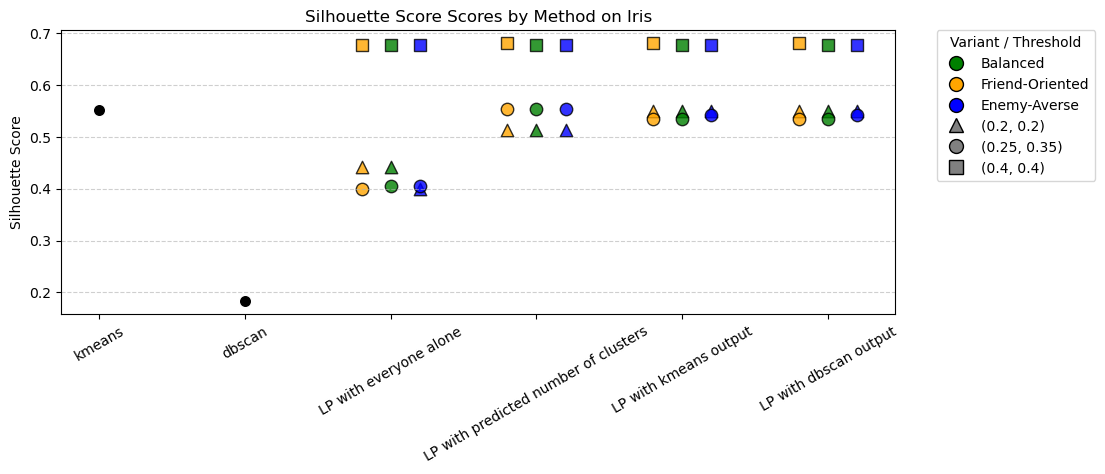

In [109]:
plot_and_save(dfs, labels, 'Iris', "Silhouette Score")

Figure saved as /Users/User/Downloads/local-popular-main-final/Cancer-Rand Index.png


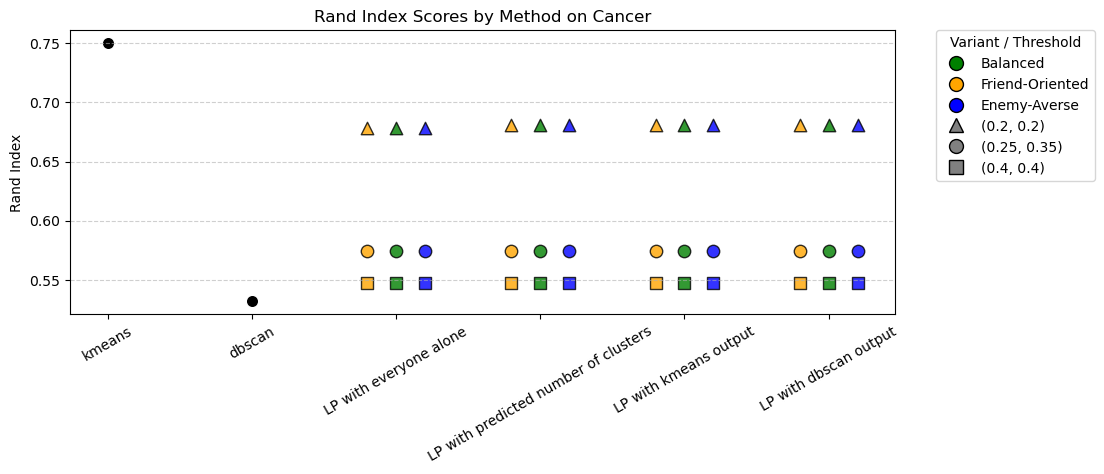

Figure saved as /Users/User/Downloads/local-popular-main-final/Cancer-Silhouette Score.png


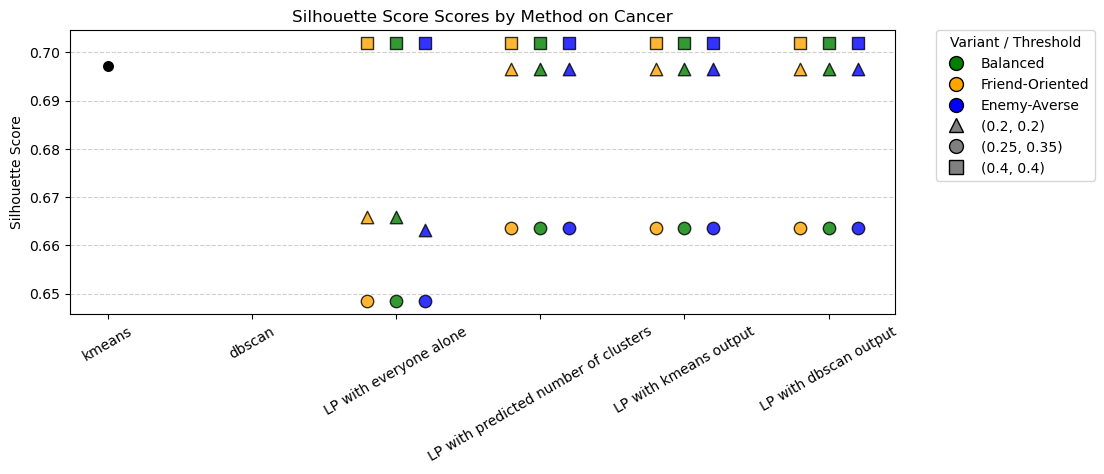

Figure saved as /Users/User/Downloads/local-popular-main-final/Cancer-Davies Bouldin Score.png


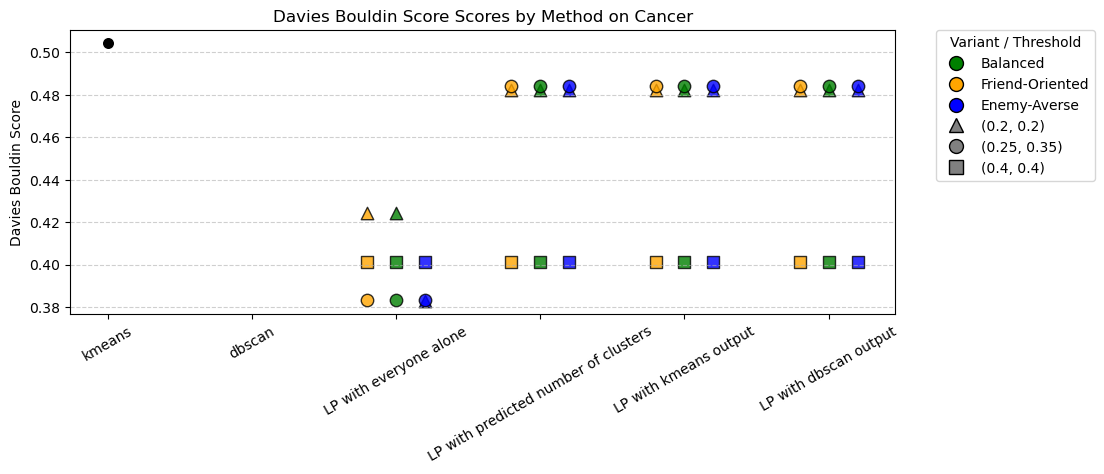

Figure saved as /Users/User/Downloads/local-popular-main-final/Iris-Rand Index.png


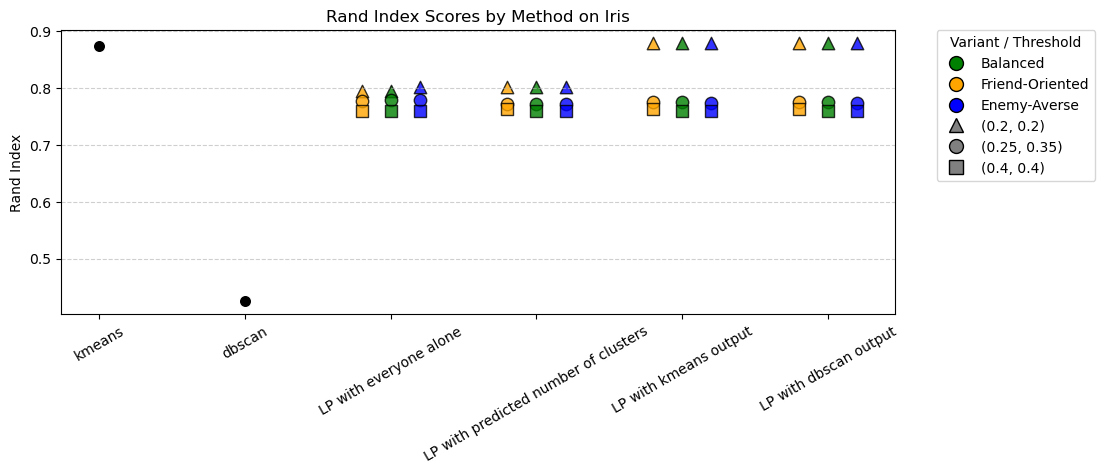

Figure saved as /Users/User/Downloads/local-popular-main-final/Iris-Silhouette Score.png


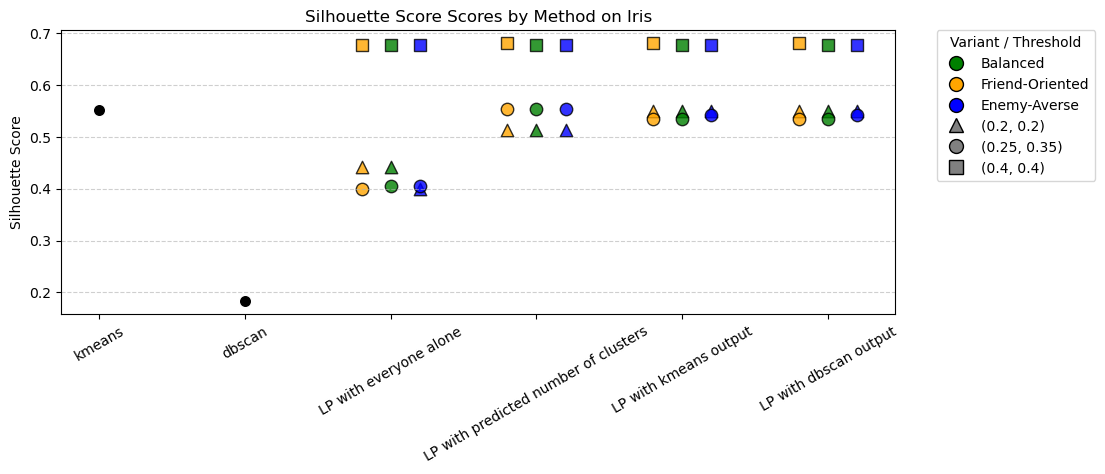

Figure saved as /Users/User/Downloads/local-popular-main-final/Iris-Davies Bouldin Score.png


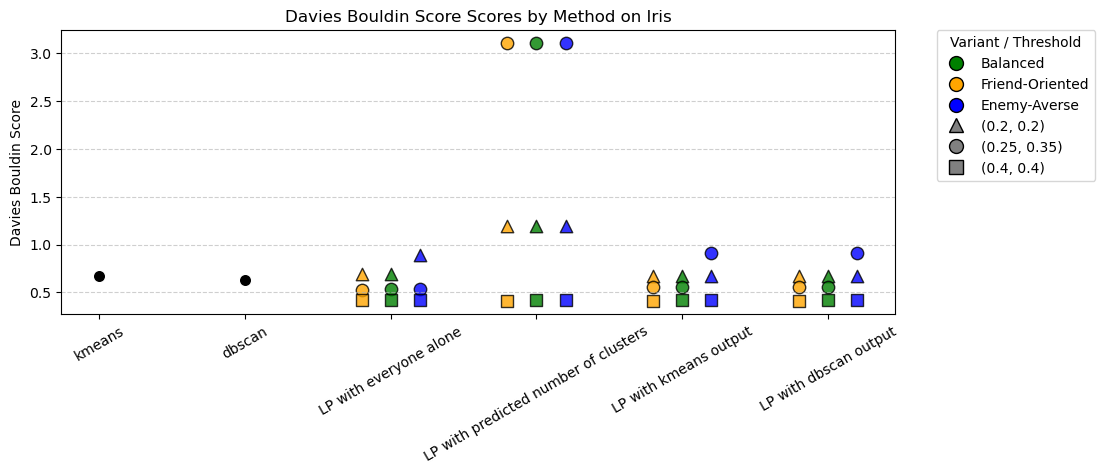

Figure saved as /Users/User/Downloads/local-popular-main-final/Moons-Rand Index.png


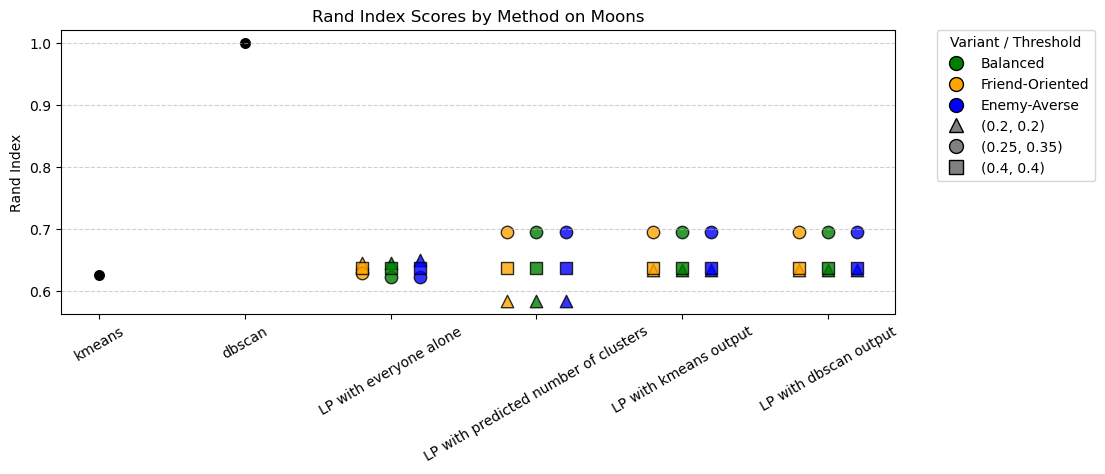

Figure saved as /Users/User/Downloads/local-popular-main-final/Moons-Silhouette Score.png


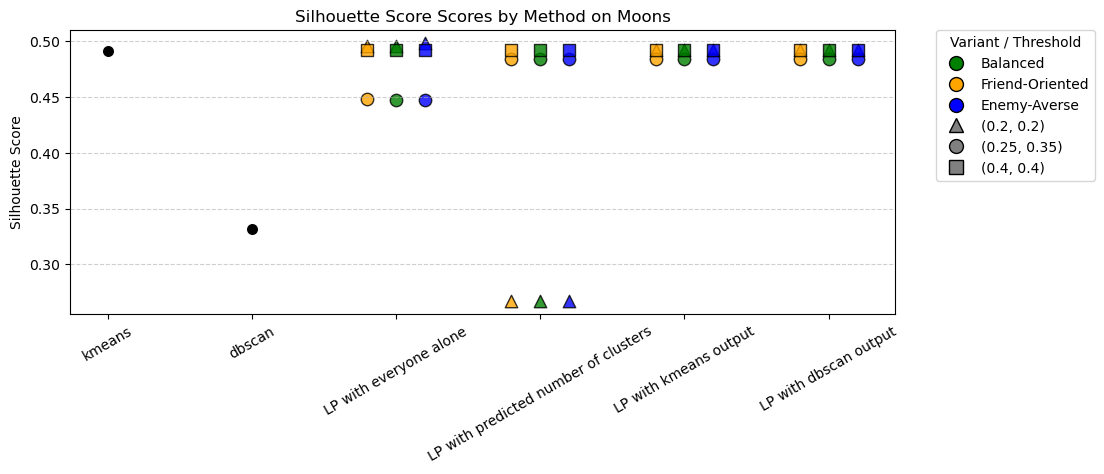

Figure saved as /Users/User/Downloads/local-popular-main-final/Moons-Davies Bouldin Score.png


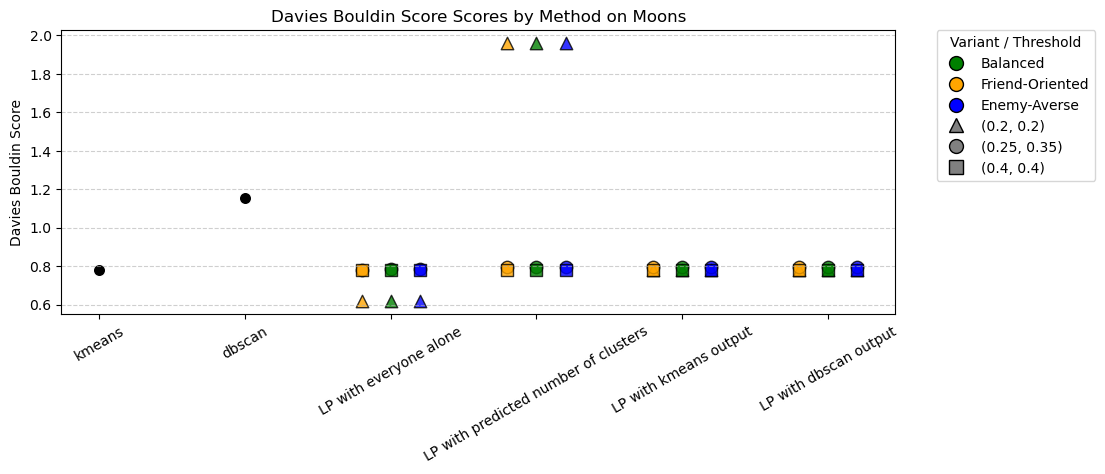

Figure saved as /Users/User/Downloads/local-popular-main-final/My 3 Circles-Rand Index.png


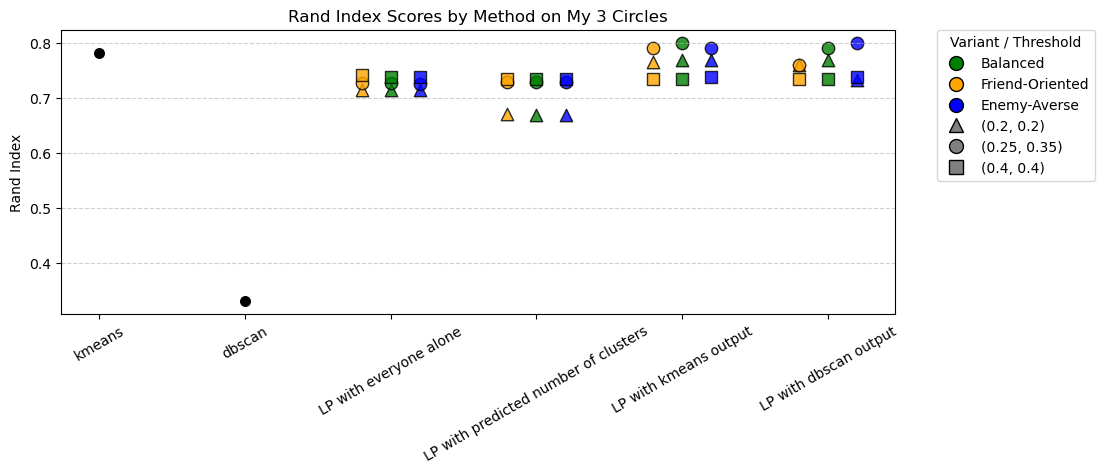

Figure saved as /Users/User/Downloads/local-popular-main-final/My 3 Circles-Silhouette Score.png


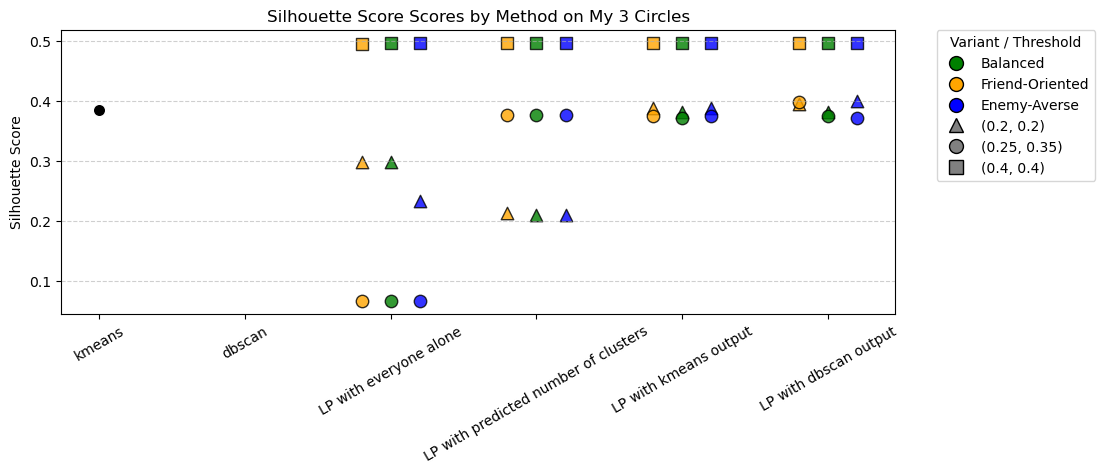

Figure saved as /Users/User/Downloads/local-popular-main-final/My 3 Circles-Davies Bouldin Score.png


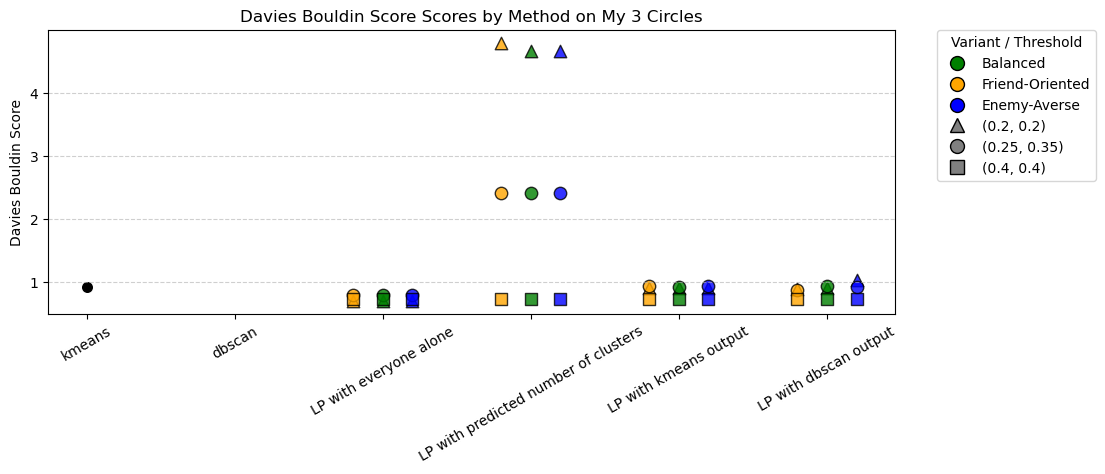

In [110]:
for Dataset in ['Cancer' ,'Iris', 'Moons' ,'My 3 Circles']:
    for score in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        plot_and_save(dfs, labels, Dataset, score, save_path=f'/Users/User/Downloads/local-popular-main-final/{Dataset}-{score}.png')